# 1. Introdução e Importação de Dados
Nesse trabalho temos como análise multivariada básica usando o dataset Titanic.
Objetivos: limpeza e tratamento dos dados, exploração descritiva, análise de correlações e aplicação de técnicas multivariadas (agrupamento via K-Means).
# 1. Descrição do Dataset
O dataset usado é `titanic.csv` (manifeste de passageiros do Titanic). Ele contém informações pessoais e de viagem dos passageiros, bem como o desfecho (`sobreviveu`).

Principais colunas: `pclass` (classe), `survived` (sobreviveu), `name` (nome), `sex` (sexo), `age` (idade), `sibsp` (irmãos/cônjuges a bordo), `parch` (pais/filhos a bordo), `ticket` (nº do bilhete), `fare` (tarifa), `cabin` (cabine), `embarked` (porto de embarque).

Breve observação: o dataset possui valores ausentes em algumas colunas (por exemplo `age` e `cabin`) e mistura variáveis numéricas e categóricas, por isso o devido tratamento prévio. 

In [17]:
import numpy as np
import pandas as pd

#noemando o banco de daodos de dados_titanic
dados_titanic = pd.read_csv('titanic3.csv')
#listando as colunas 
#print(dados_titanic.columns)
 
#pclass: classe do passageiro
#survived: sobreviveu (1 = sim, 0 = não)
#name: nome
#sex: sexo
#age: idade
#sibsp: número de irmãos/cônjuges a bordo
#parch: número de pais/filhos a bordo
#ticket: número do bilhete
#fare: tarifa paga
#cabin: cabine
#embarked: porto de embarque
#boat: bote salva-vidas
#body: número do corpo (identificação de vítimas)
#home.dest: destino residencial

#renomeando colunas
dados_titinaic = dados_titanic.rename(columns={
    "pclass": "classe",
    "survived": "sobreviveu",
    "name": "nome",
    "sex": "sexo",
    "age": "idade",
    "sibsp": "irmaos/conjuges_a_bordo",
    "parch": "pais/filhos_a_bordo",
    "ticket": "bilhete",
    "fare": "tarifa",
    "cabin": "cabine",
    "embarked": "embarque",
    "boat": "bote_salva_vidas",
    "body": "mortos_identificados",
    "home.dest": "destino_residencial"
}, inplace=True)

#convertendo as colunas para o tipo de dados
dados_titanic1 = dados_titanic.astype({"idade": float,
                                        "sobreviveu": 'category',
                                         'pais/filhos_a_bordo': int,
                                         'irmaos/conjuges_a_bordo': int,
                                         "tarifa": float,
                                          'sexo' : "category",
                                           'classe': 'category',
                                             'bilhete': 'category',
                                                   })

#removendo valores missing (nulos)
dados_titanic1 = dados_titanic1.dropna(subset=["idade", "tarifa"])
print(dados_titanic1[cols_numericas].info())


### 1.2. Medidas descritivas — tendência central, dispersão e diagnóstico de distribuição
Nesta seção vamos além das estatísticas básicas: explicamos as medidas, como calculá-las, e o que fazer quando encontrarmos assimetria ou outliers.

Principais medidas e fórmulas rápidas:
- Média (mean): sensível a outliers.
- Mediana (median): posição central; robusta a outliers.
- Variância (var); desvio padrão = sqrt(var).
- Quartis e IQR: Q1 (25%), Q3 (75%), IQR = Q3 - Q1 — útil para detectar outliers (1.5*IQR regra).
- Assimetria (skewness): medidor de simetria. Skew>1 sugere assimetria positiva; Skew<-1, assimetria negativa.
- Curtose (kurtosis): mede o peso das caudas. Curtose alta = caudas pesadas (mais outliers).

Processo realizados nesta seção:
1) Estatísticas descritivas (mean, median, std, min, max, skew, kurt).
2) Histogramas e boxplots para cada variável numérica (visualizar forma e outliers).
3) Contar outliers por coluna com a regra 1.5 * IQR e avaliar impacto.
4) realizar tratamentos nos outlers
5) Reavaliar medidas (skew/kurtosis) após transformação para confirmar redução de assimetria.



In [29]:
import seaborn as sns
from scipy.stats import skew, kurtosis

# Gráficos boxplot para visualizar distribuição e outliers de cada variável numérica
import matplotlib.pyplot as plt
print(dados_titanic1[cols_numericas].describe().round(2))

# Selecionar apenas variáveis numéricas
#cols_numericas = ['idade', 'tarifa', 'irmaos/conjuges_a_bordo', 'pais/filhos_a_bordo']

# Estatísticas descritivas com skewness e kurtosis
#print("Estatísticas Descritivas")
#for i in cols_numericas:
#    print(f"\n{i}:")
#    print(f"  Média: {dados_titanic1[i].mean():.2f}")
#    print(f"  Mediana: {dados_titanic1[i].median():.2f}")
#    print(f"  Desvio Padrão: {dados_titanic1[i].std():.2f}")
#    print(f"  Mín: {dados_titanic1[i].min():.2f}, Máx: {dados_titanic1[i].max():.2f}")
#    print(f"  Skewness: {skew(dados_titanic1[i]):.2f}")
#    print(f"  Kurtosis: {kurtosis(dados_titanic1[i]):.2f}")

         idade   tarifa  irmaos/conjuges_a_bordo  pais/filhos_a_bordo
count  1045.00  1045.00                  1045.00              1045.00
mean     29.85    36.69                     0.50                 0.42
std      14.39    55.73                     0.91                 0.84
min       0.17     0.00                     0.00                 0.00
25%      21.00     8.05                     0.00                 0.00
50%      28.00    15.75                     0.00                 0.00
75%      39.00    35.50                     1.00                 1.00
max      80.00   512.33                     8.00                 6.00


 Após a limpeza dos dados (remoção de valores ausentes em idade e tarifa), o dataset foi reduzido a **1045 registros**. As estatísticas descritivas revelam:

- **Idade**: média de ~30 anos, mediana de 28 anos, com desvio padrão de 14.4 anos. A distribuição varia de 0.17 (2 meses de idade) a 80 anos, indicando presença de crianças recém nascidas e idosos. A assimetria leve à direita sugere uma população predominantemente jovem-adulta.

- **Tarifa**: média de ~36.69, mas com mediana de apenas ~15.75 — a forte diferença entre média e mediana indica assimetria positiva extrema (desvio padrão de 55.73). Tarifas variam de $0 a $512.33, refletindo as três classes socioeconômicas distintas. Muitos outliers de alta tarifa (classe 1) distorcem a distribuição.

- **Irmãos/Cônjuges a Bordo**: média de 0.50, mediana de 0 (maioria viajava sozinha ou desacompanhada). O máximo de 8 familiares indica algumas famílias numerosas, principalmente na classe 3.

- **Pais/Filhos a Bordo**: média de 0.42, mediana de 0 (padrão similar ao anterior). Máximo de 6 dependentes, sugerindo viagens com estruturas familiares multigeracionais.

Para aplicações posterioes a variabilidade heterogênea (desvios padrão distintos) e as distribuições assimétricas — especialmente em tarifa — justificam a padronização (z-score) antes de aplicar técncias posteirores multivariadas. Outliers extremos em tarifa podem influenciar o agrupamento; podemos fazer uso winsorização ou log-transformação conforme necessário.

### 1.3. Gráficos de barras — distribuição média e relativa
Mostramos aqui a distribuição média do número de irmãos/cônjuges por classe (classe 1/2/3) e uma representação relativa (proporção) por faixa de número de irmãos. 
Objetivo: visualizar se passageiros em classes diferentes apresentam perfis familiares distintos (médias e frequências relativas).

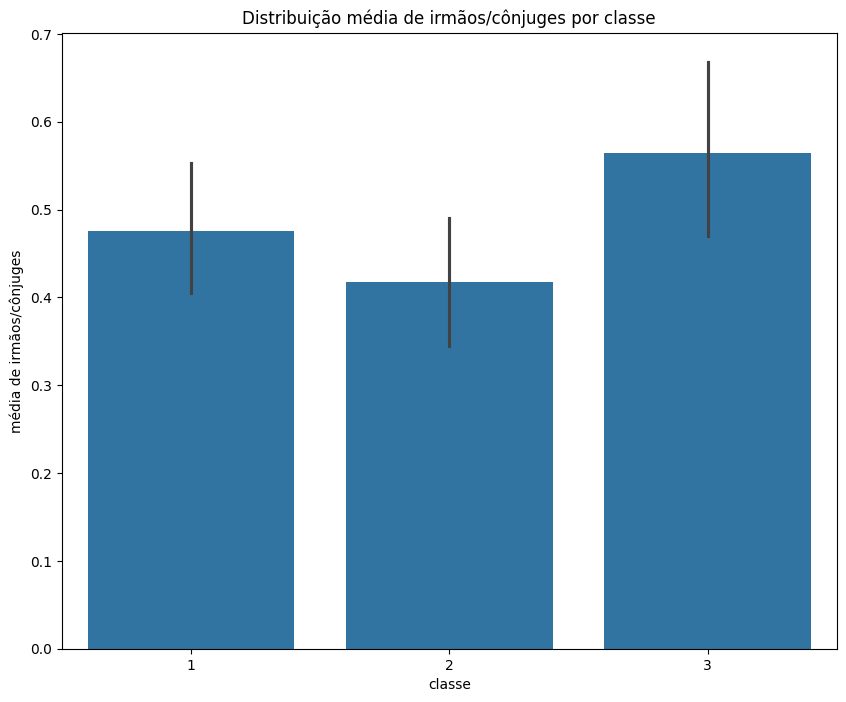

In [4]:
#graficos de barra para visualizar a distribuição das classes, sexo, bilhete e quem sobreviveu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))
sns.barplot(x = "classe", y = "irmaos/conjuges_a_bordo", data=dados_titanic1)
plt.title("Distribuição média de irmãos/cônjuges por classe")
plt.ylabel('média de irmãos/cônjuges')
plt.show()



- A média de `irmaos e conjuges a bordo` é maior na classe 3, isso sugere famílias maiores viajando nessa classe, em segundo e terceiro lugar vem as classes 1 e 2.
- O gráfico de frequência relativa mostra como a distribuição de contagens (0,1,2,...) varia por classe — útil para detectar heterogeneidade em perfis familiares.
- variáveis familiares podem estar associadas à probabilidade de sobrevivência (por exemplo, famílias maiores podem ter maior chance de resgate ou estar em áreas específicas do navio). Recomenda-se cruzar com `sobreviveu` para investigar correlação.

### 1.3.1. Frequência relativa por classe — irmãos/cônjuges
Aqui mostramos a proporção relativa de cada contagem de `irmãos e cônjuges` por cada classe de passageiros.
Por que isso importa:
- Permite comparar a distribuição completa (não só média) entre classes; por exemplo, duas classes podem ter médias parecidas, mas estruturas de frequência muito diferentes.
- Útil para entender padrões sociais e econômicos: quem viajava em família vs sozinho por classe.

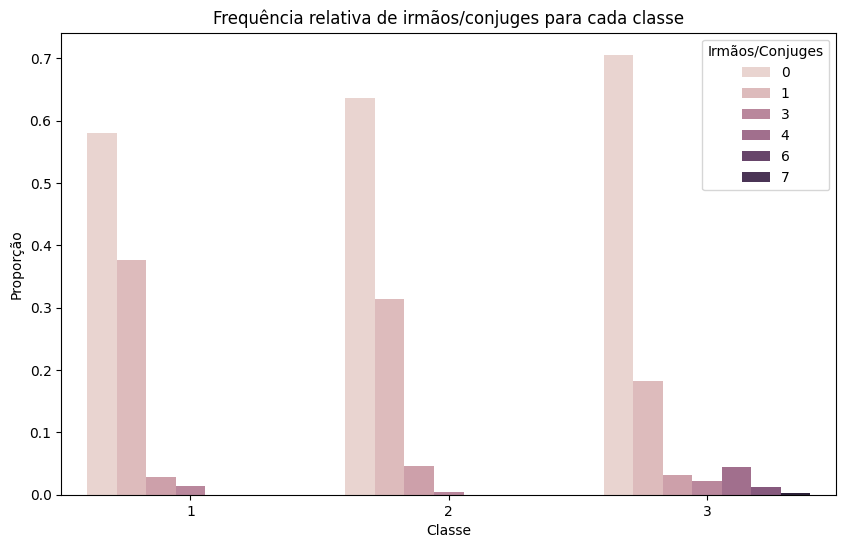

In [ ]:
# Gráfico de barras com frequência relativa das classes usando seaborn
frequencia_irmaos = (
    dados_titanic1.groupby('classe', observed= True)['irmaos/conjuges_a_bordo']
    .value_counts(normalize=True)
    .rename('proporcao')
    .reset_index()
)
plt.figure(figsize=(10,6))
sns.barplot(x='classe', y='proporcao', hue='irmaos/conjuges_a_bordo', data=frequencia_irmaos)
plt.title('Frequência relativa de irmãos/conjuges para cada classe')
plt.ylabel('Proporção')
plt.xlabel('Classe')
plt.legend(title='Irmãos/Conjuges')
#plt.show()

- Este gráfico mostra a proporção de passageiros com 0, 1, 2... irmãos/cônjuges por classe.
- Útil para comparar a distribuição completa: duas classes podem ter médias semelhantes como vimos no gráfico anterior, mas padrões de frequência muito distintos principalmente nas classes 1 e 3. Na classe 3 diferentemente da 1 podemos vê que muitos passageiros possuiam mais familiares em sua companhia do que a 1, visto que tal classe mais rica possuia gente com maiores condições fincaceiras dificlmente a familia tinha mais de 3 filhos com as classe mais barata. 
- Observação: picos em 0 (viajantes sozinhos) ou picos em 1/2 (familias pequenas) e se esses padrões variam por classe. Isso pode ser indicativo de diferenças socioeconômicas ou preferências de viagem.

### 1.3.2. Boxplots — detecção de outliers e distribuição por variável numérica
Os boxplots visualizam a distribuição de cada variável numérica, destacando a mediana, quartis e outliers. Esta análise complementa as estatísticas descritivas (média, desvio padrão, skewness) e permite identificar valores anormais que podem impactar análises posteriores (e.g., K-Means é sensível a outliers).

Elementos do boxplot:
- **Caixa**: representa o intervalo interquartil (IQR = Q3 − Q1); contém 50% dos dados.
- **Linha dentro da caixa**: mediana (Q2).
- **Bigodes**: estendem-se até 1.5 × IQR; além disso, pontos são marcados como outliers.
- **Pontos isolados**: valores extremos (outliers) que podem distorcer modelos.

Ações recomendadas:
- Se muitos outliers forem detectados, considere **winsorização** (limitar valores extremos) ou **log-transformação** (especialmente para variáveis assimétricas como tarifa).
- Compare o padrão de outliers entre variáveis; se uma variável tem muitos outliers, investigue se são erros de entrada ou valores legítimos (ex.: tarifas muito altas para primeira classe).

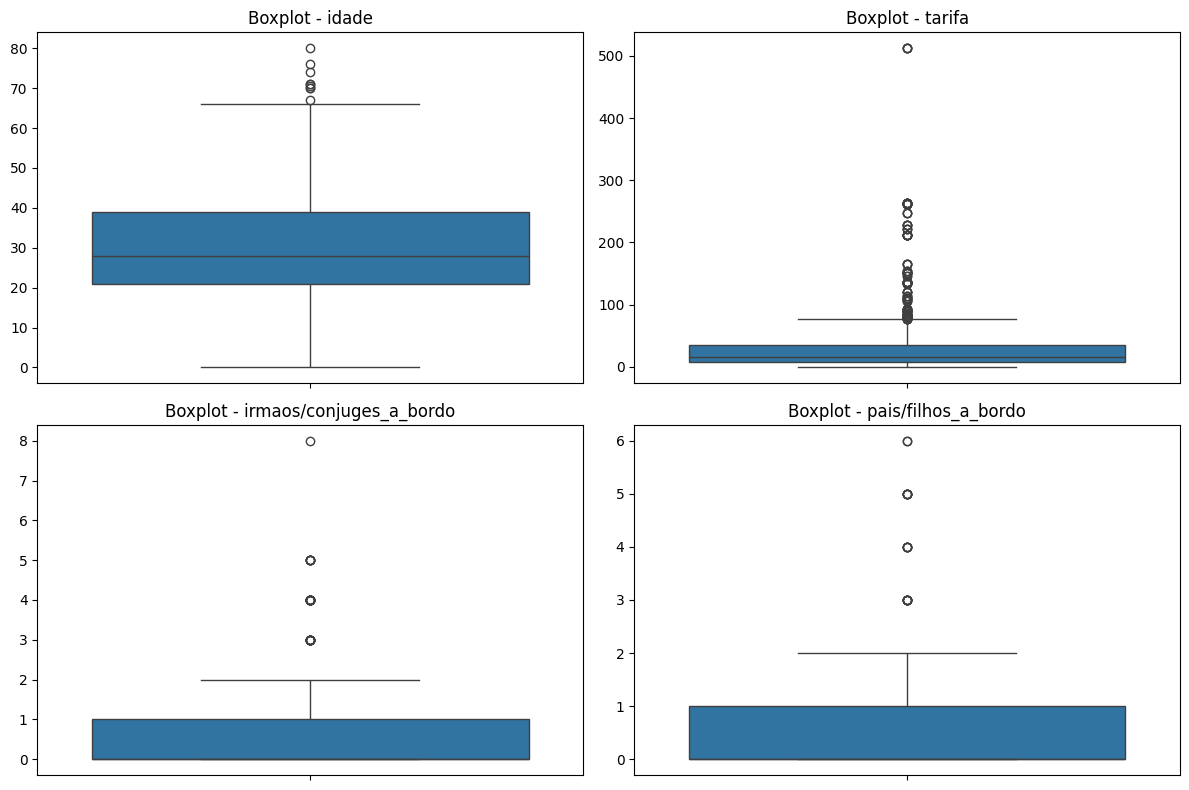

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, col in enumerate(cols_numericas):
    sns.boxplot(y=dados_titanic1[col], ax=axes[idx])
    axes[idx].set_title(f'Boxplot - {col}')
    # remover apenas o texto do rótulo Y
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()




Os boxplots acima visualizam a distribuição de cada variável numérica, destacando a mediana, quartis e outliers presentes em cada uma delas.

- **Idade**: A distribuição apresenta mediana em torno de 28 anos, com a maioria dos passageiros concentrados entre 20 e 40 anos (IQR). Há presença de outliers nas extremidade superior a 60 anos (idosos), principalmente acima de 65 anos. A assimetria é ligeiramente positiva, sugerindo uma cauda mais longa para idades maiores.

- **Tarifa**: Esta variável mostra forte assimetria à direita, com mediana em torno de 15,75 unidades monetárias, mas com outliers extensos atingindo valores superiores a 500. A maioria dos passageiros pagou tarifas baixas (classe 3), enquanto alguns poucos (primeira classe) pagaram valores muito elevados. Essa distribuição é altamente assimétrica a direita devido a mediana está mais proxima do limite inferior

- **Irmãos/Cônjuges a Bordo**: Apresenta forte concentração em zero (viajantes sozinhos), com mediana = 0. Há alguns outliers até 4 (familias numerosas), mas a maioria dos passageiros viajava desacompanhada de irmãos ou cônjuges. A distribuição é discreta e concentrada nas extremidades.

- **Pais/Filhos a Bordo**: Similar à anterior, com concentração em zero (passageiros sem filhos ou pais a bordo). A mediana é 0, com outliers atingindo até 6. A maioria viajava sem dependentes diretos, refletindo o padrão de viagens individuais ou de casais naquela época.


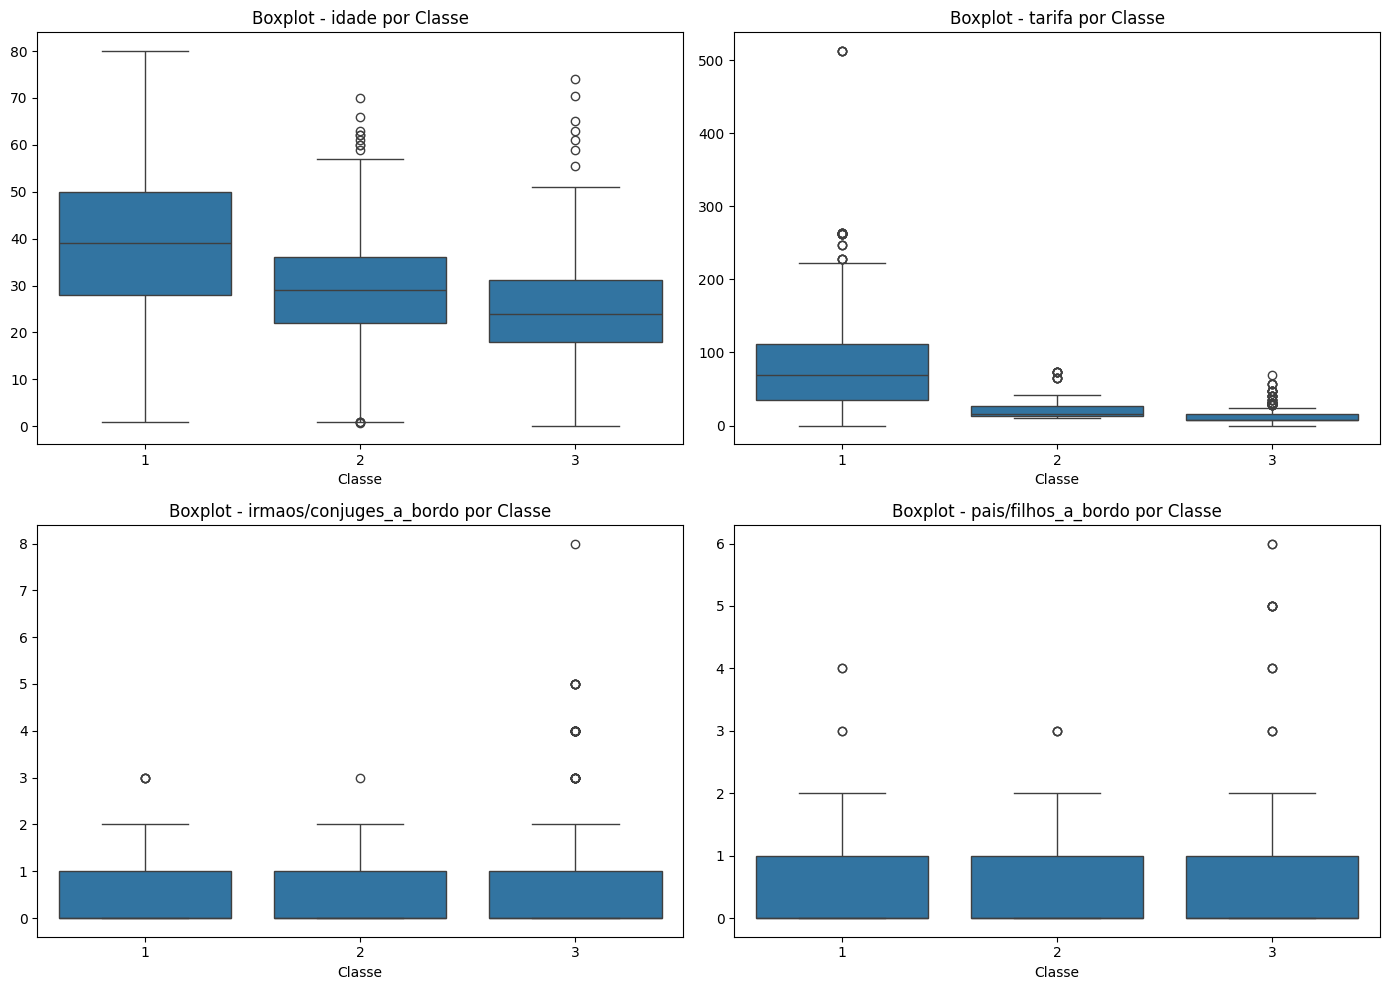

In [ ]:
# Criar boxplots para cada variável numérica agrupada por classe
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(cols_numericas):
    sns.boxplot(x='classe', y=col, data=dados_titanic1, ax=axes[idx])
    axes[idx].set_title(f'Boxplot - {col} por Classe')
    axes[idx].set_xlabel('Classe')
    axes[idx].set_ylabel(col)
    # remover apenas o texto do rótulo Y
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()


Os boxplots agrupados por classe revelam padrões importantes sobre como as variáveis numéricas variam entre os diferentes grupos socioeconômicos de passageiros:

**Idade por Classe:**
- A distribuição de idade é relativamente similar entre as três classes, com medianas variando de a 20-40 anos.
- A classe 1 apresenta uma ligeira concentração de passageiros mais velhos (65+ anos), refletindo a presença de idosos mais abastados.
- As classes 2 e 3 têm distribuições mais simétricas, apresenta alguns outliers extremos, porém sugeri uma população mais jovem se comparada a classe 1 .
- A variabilidade é varia entre as classes, indicando que a idade é um forte diferenciador de classe social no Titanic.

**Tarifa por Classe:**
- Diferenças marcantes e esperadas: a classe 1 apresenta tarifas muito mais altas (mediana > 50, máximo > 500), refletindo o luxo da primeira classe.
- A classe 2 tem tarifas intermediárias (mediana ~13-15), enquanto a classe 3 concentra-se em tarifas baixas (mediana ~7-8).
- A classe 1 mostra forte assimetria com muitos outliers superiores — alguns passageiros pagaram tarifas extraordinariamente altas.
- As classes 2 e 3 têm distribuições mais compactas e concentradas, com alguns outliers, refletindo tarifas padronizadas e baixas.
- Conclusão: tarifa é o principal diferenciador de classe; validando a estratificação econômica do dataset.

**Irmãos/Cônjuges a Bordo:**
- Todas as três classes mostram forte concentração em zero (viajantes sozinhos ou sem cônjuges).
- A classe 3 apresenta uma cauda um pouco mais longa, com mais casos de 2-4 irmãos/cônjuges — sugerindo famílias maiores viajando na classe mais barata.
- As classes 1 e 2 têm distribuições mais estreitas, com medianas = 0 e poucos outliers, indicando maior proporção de viajantes desacompanhados.
- Observação: famílias numerosas parecem ter viajado principalmente na classe 3, possivelmente por razões econômicas (imigração em grupo, repatriação).

**Pais/Filhos a Bordo:**
- Padrão similar ao anterior: concentração em zero em todas as classes, com mediana = 0.
- A classe 3 novamente mostra mais outliers (até 6), refletindo a presença de famílias maiores com crianças/pais dependentes.
- As classes 1 e 2 têm menos passageiros viajando com dependentes diretos, sugerindo maior proporção de adultos independentes ou casais sem filhos.
- Interpretação: a classe 3 agrupava perfis de viagem familiar/multigeracional, enquanto classes 1 e 2 tinham maior proporção de viajantes individuais ou de casais.

**O que podemos tirar dessa analise!**
- Classe 1 = passageiros de elite, com tarifas muito altas, distribuição de idade com mais idosos, e predominância de viajantes individuais.
- Classe 2 = passageiros de classe média, tarifas intermediárias, idade média, poucas famílias numerosas.
- Classe 3 = passageiros de classe baixa/imigrantes, tarifas muito baixas, distribuição de idade variada, com maior proporção de famílias numerosas.
- A classe social é claramente associada não apenas à tarifa paga, mas também ao perfil demográfico e estrutura familiar dos passageiros — fatores que podem ter influenciado as chances de sobrevivência durante o desastre.


### 1.4. Matriz de Correlação (Pearson) — relações lineares entre variáveis numéricas
Nesta seção calculamos a matriz de correlações Pearson entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

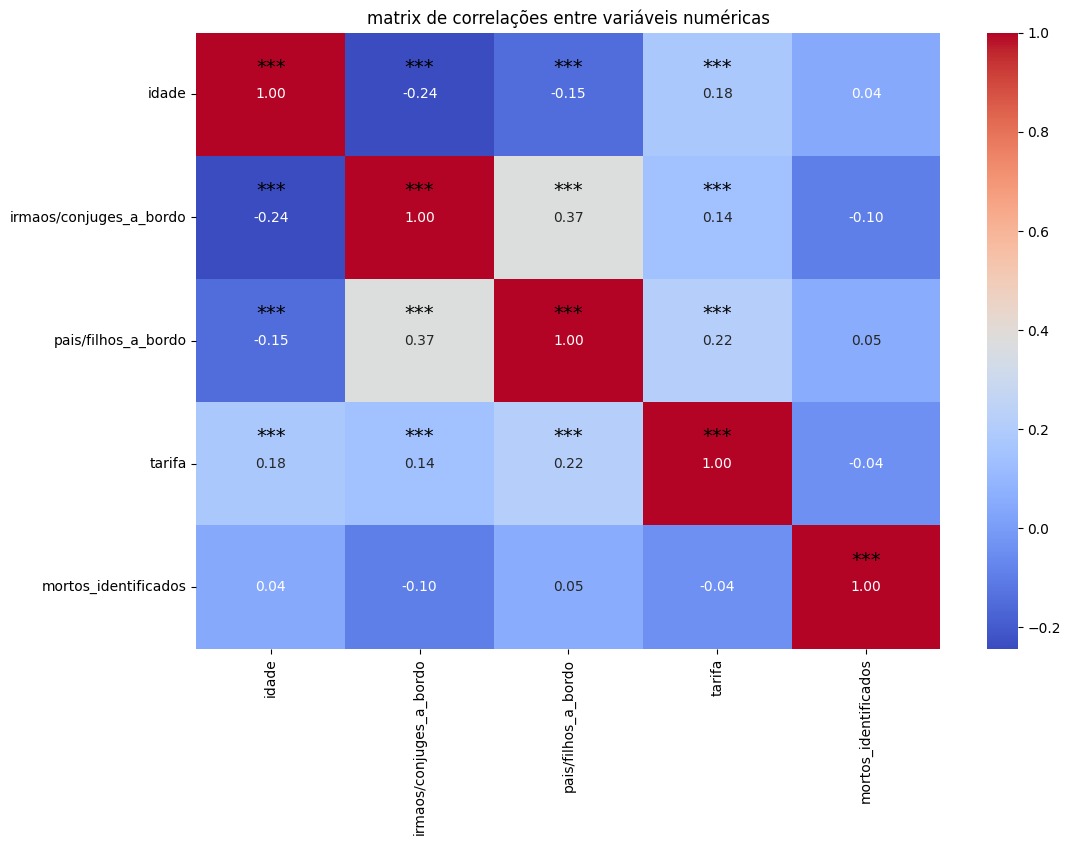

In [ ]:
from scipy.stats import pearsonr

# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
corr = dados_titanic1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
# calcular p-values de Pearson para cada par de variáveis
cols = corr.columns.tolist()
pvals = pd.DataFrame(np.nan, index=cols, columns=cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        x = dados_titanic1[cols[i]]
        y = dados_titanic1[cols[j]]
        mask = x.notna() & y.notna()
        if mask.sum() > 2:
            _, p = pearsonr(x[mask], y[mask])
        else:
            p = np.nan
        pvals.iloc[i, j] = p

# função para transformar p-value em estrelas de significância
def sig_stars(p):
    if pd.isna(p):
        return ''
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

# anotar estrelas de significância sobre o heatmap
ax = plt.gca()
n = len(cols)
for i in range(n):
    for j in range(n):
        star = sig_stars(pvals.iloc[i, j])
        if star:
            # posicionar a estrela levemente acima do número da correlação
            ax.text(j + 0.5, i + 0.28, star, ha='center', va='center', color='black', fontsize=14)

plt.show()

- A matriz mostra coeficientes de correlação linear entre pares de variáveis numéricas (-1 a 1).
- Valores próximos de 1 ou -1 indicando forte associação linear; esses pares podem indicar redundância (colinearidade) ou relacionamento direto.
- Parace que nehumas das variáveis paarce está fortemente associada umas as outras.
- Lembrar: correlação não implica causalidade; use a matriz como um sinalizador para investigações adicionais (regressão, análise de variância, etc.).

### 1.5. Matriz de Pares (Pairplot) — explorar distribuições e relações bivariadas
O pairplot exibe histogramas/distribuições univariadas e gráficos de dispersão para pares de variáveis. É útil para inspecionar tendências, padrões e possíveis relações não-lineares, e para detectar outliers conjuntos que podem influenciar análises posteriores.

Interpretações comuns:
- Verifique se há agrupamentos naturais visíveis com base nas variáveis, que podem indicar segmentos de passageiros.
- Procure por padrões não-lineares que a correlação de Pearson não captaria.
- Combine essa análise com a matriz de correlação (1.4) para formar uma visão completa.

<Figure size 1200x800 with 0 Axes>

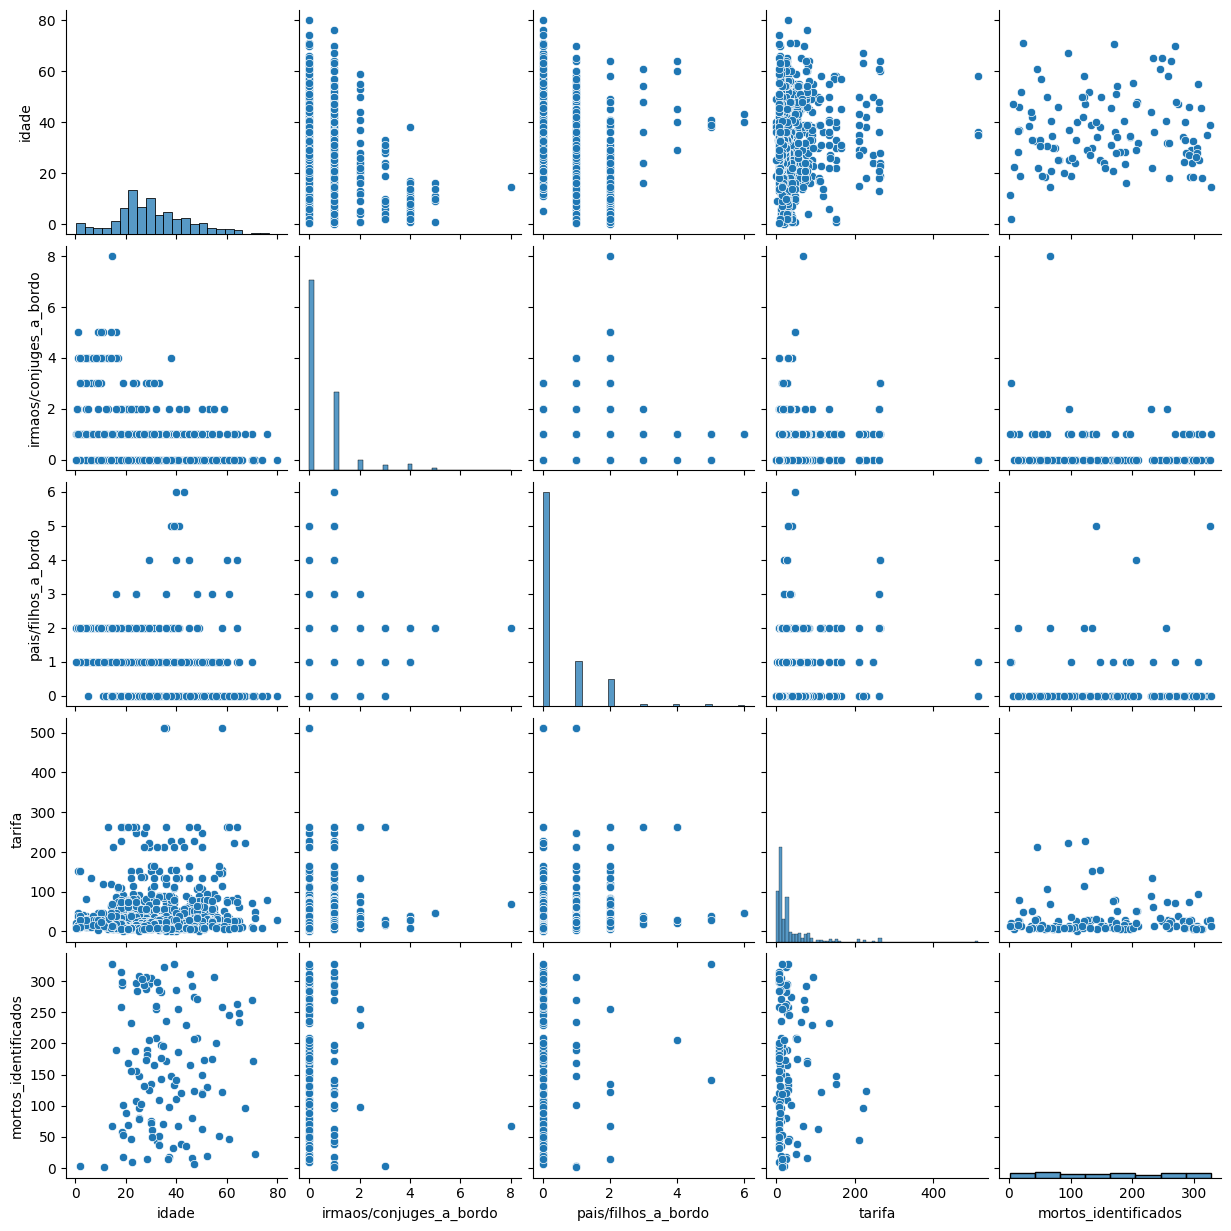

In [ ]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
dados_numeric = dados_titanic1.select_dtypes(include=[np.number])
sns.pairplot(dados_numeric)



- O pairplot mostra a distribuição univariada na diagonal e gráficos de dispersão entre pares de variáveis.
- Ele é interessante para identificar relações não-lineares, heterocedasticidade e agrupamentos visíveis; também ajuda a detectar outliers em múltiplas dimensões. Observa-se vários agrupamentos no eixo idade — a maior densidade de casos está entre 20 e 60 anos, com contagens que variam de poucas dezenas até algumas centenas nos picos.
- No gráfico `idade x tarifa` percebe‑se que a mesma faixa etária (cerca de 20–60 anos) concentra os maiores valores de tarifa (ex.: picos próximos a 300–500), enquanto a maioria das tarifas fica em faixas baixas (próximas a 100–200). Isso indica forte assimetria à direita em tarifa e alguns outliers de alta tarifa provavelmente vinculados à classe superior.
- As variáveis familiares (`irmaos e/ou conjuges a bordo` e `pais e/ou filhos a bordo`) apresentam concentração em 0 e 1, sugerindo muitos viajantes sozinhos ou em pequenas famílias; estas variáveis aparecem pouco correlacionadas linearmente com idade, mas podem segmentar perfis sociais quando combinadas com tarifa e classe.
- Há evidências de heterocedasticidade: a variabilidade da tarifa aumenta em certas faixas etárias (mais dispersão entre 20–60 anos), o que pode afetar modelos que assumem variância constante.
- Implicações práticas: considerar log-transformação de `tarifa` (para reduzir skew) e padronização (zscore) antes de aplicar K-Means; tratar ou winsorizar outliers extremos; e, se necessário, usar PCA/t‑SNE para visualizar melhor agrupamentos multivariados.
- Observação prática: aparecerem agrupamentos visíveis, eles podem sinalizar segmentos naturais — isso é útil para formar hipóteses iniciais para clustering.

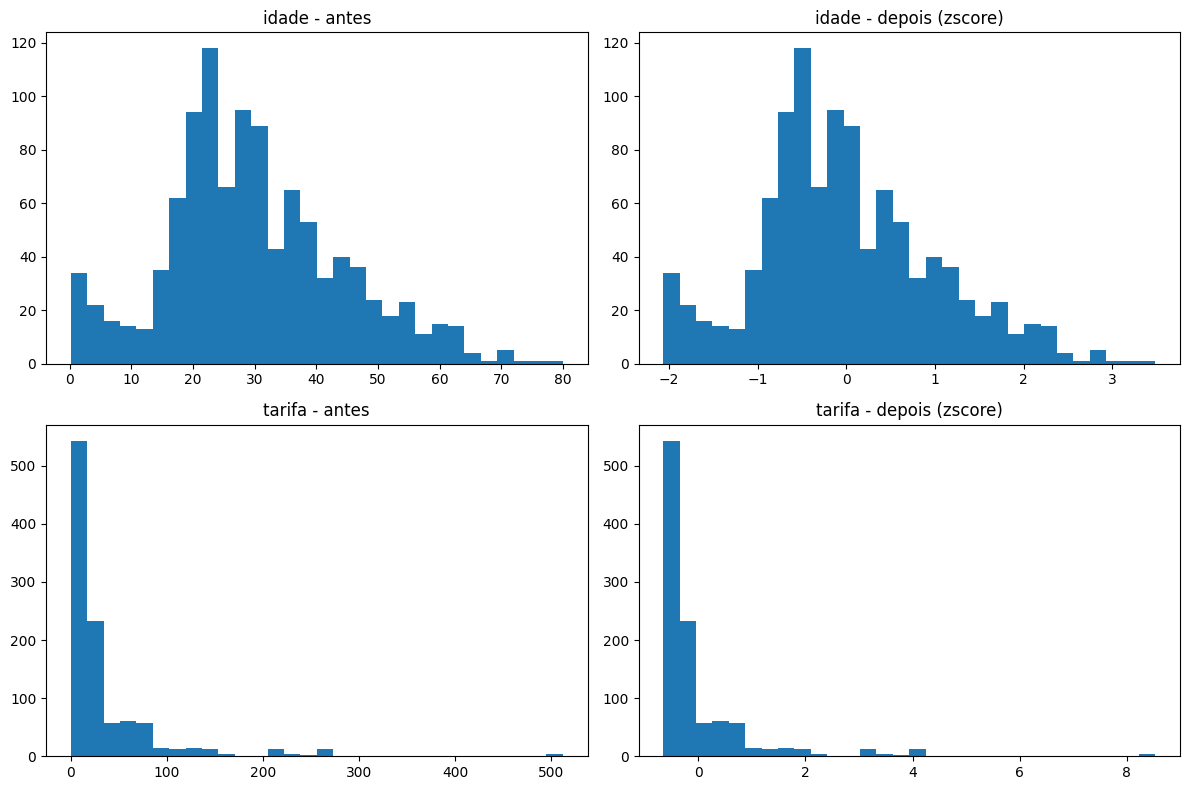

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Exemplo de uso da função convert_to_same_units
import matplotlib.pyplot as plt
# Selecionar colunas
cols = ['idade','tarifa', "irmaos/conjuges_a_bordo", "pais/filhos_a_bordo"]
X = dados_titanic1[cols]
#print('Antes (amostra):')
#print(X.describe())
# Função utilitária para padronizar/normalizar colunas

def convert_to_same_units(df, cols, method='zscore', log_transform=False, return_scaler=False):
    """
    Converte/escala colunas selecionadas do DataFrame.
    - df: DataFrame original
    - cols: lista de colunas numéricas a serem transformadas
    - method: 'zscore' (StandardScaler) ou 'minmax' (MinMaxScaler)
    - log_transform: se True aplica np.log1p antes do escalonamento (assume valores >= 0)
    - return_scaler: se True retorna (X_scaled_df, scaler), caso contrário retorna apenas X_scaled_df
    """
    X = df[cols].astype(float).copy()
    
    if log_transform:
        # checar valores negativos que impediriam log1p
        if (X < 0).any().any():
            raise ValueError("Existem valores negativos em cols — não é possível aplicar log1p.")
        X = np.log1p(X)
    
    if method == 'zscore':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("method deve ser 'zscore' ou 'minmax'")
    
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=cols, index=df.index)
    
    if return_scaler:
        return X_scaled, scaler
    return X_scaled
# Aplicar padronização zscore (StandardScaler)
# Também é possível usar a função apenas para retornar um dataset escalado sem alterar o DataFrame original:
X_scaled_df, scaler = convert_to_same_units(dados_titanic1, cols, method='zscore', return_scaler=True)
#print('Depois (amostra):')
#display(X_scaled_df.describe())

# Histogramas antes / depois
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].hist(X['idade'].dropna(), bins=30); axes[0,0].set_title('idade - antes')
axes[0,1].hist(X_scaled_df['idade'].dropna(), bins=30); axes[0,1].set_title('idade - depois (zscore)')
axes[1,0].hist(X['tarifa'].dropna(), bins=30); axes[1,0].set_title('tarifa - antes')
axes[1,1].hist(X_scaled_df['tarifa'].dropna(), bins=30); axes[1,1].set_title('tarifa - depois (zscore)')
plt.tight_layout(); plt.show()

# Exemplos adicionais:
# X_minmax, scaler = convert_to_same_units(dados_titanic1, cols, method='minmax', return_scaler=True)
# X_log, scaler = convert_to_same_units(dados_titanic1, ['tarifa'], method='minmax', log_transform=True, return_scaler=True)


A padronização (z‑score) preserva a forma da distribuição original — skewness, mediana e outliers permanecem — alterando apenas escala (média = 0, desvio = 1).  Isso permite comparar variáveis com unidades distintas (idade, tarifa, contagens) sem distorcer suas relações relativas.  
Para K‑Means, evita que variáveis de maior magnitude dominem a distância euclidiana, melhorando a identificação de clusters.  Dado que não há valores negativos problemáticos e as variáveis têm magnitudes distintas, o z‑score é apropriado e robusto para estes dados.

### Para o algoritmo K-Means `dados_titanic1`
Nesta célula aplicamos o método K-Means (K-Médias) ao dataset `dados_titanic1`. A escolha de `k` é baseada no método do cotovelo, que avalia a inércia (somatório das distâncias ao quadrado até o centróide) para diferentes valores de `k`.
Variáveis usadas: `idade` e `tarifa` (para visualização e formação do cluster), e as outras variáveis escalonadas como `irmaos/conjuges_a_bordo` e `pais/filhos_a_bordo` foram preparadas no dataset para análises políticas posteriores.

Fluxo de passos aplicados aqui:
1) Selecionar as colunas relevantes; 2) Padronizar usando `convert_to_same_units`; 3) Rodar o método do cotovelo para encontrar `k` provável; 4) Treinar K-Means com `k` escolhido; 5) Converter centroides de volta para unidades originais com `inverse_transform`; 6) Visualizar os clusters e interpretar centróides.

Observações: para garantir reprodutibilidade e clareza, usamos `return_scaler=True` para manter o objeto `scaler` que permite converter os centróides de volta para as unidades originais (ex.: tarifa em moeda).

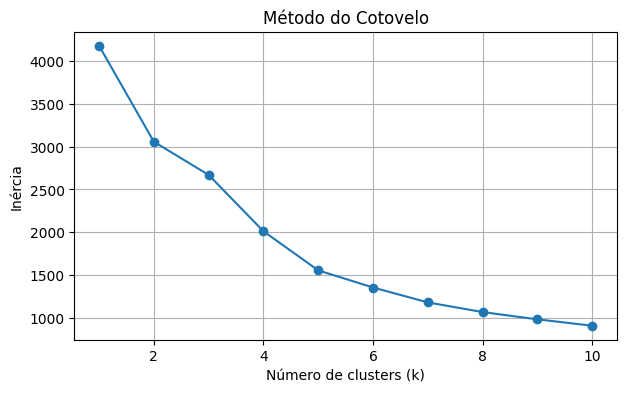

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ===== 3. Método do Cotovelo =====
inertias = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled_df)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertias, marker="o")
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.grid(True)
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled_df)
dados_titanic1["clusters"] = cluster_labels


- O método do Cotovelo mostra a inércia em função do número de clusters (k); um ponto onde a curva se estabiliza indica um `k` razoável a ser usado.
- No scatter plot (idade vs tarifa), cada cor indica um cluster atribuído pelo K-Means. Observe a localização dos centróides (marcados e rotulados) para entender o perfil central de cada grupo.
- Interpretação prática: use `centroides_reais` para descrever cada cluster (ex.: cluster C0 = jovens com tarifa baixa; C1 = adultos com tarifa média). Em seguida, calcule estatísticas por cluster (média/id, tarifa, taxa de sobrevivência) para quantificar diferenças.
- Observação: K-Means é sensível ao escalonamento e outliers; como as variáveis foram padronizadas e acaba por ter mais robustez a outliers extremos.

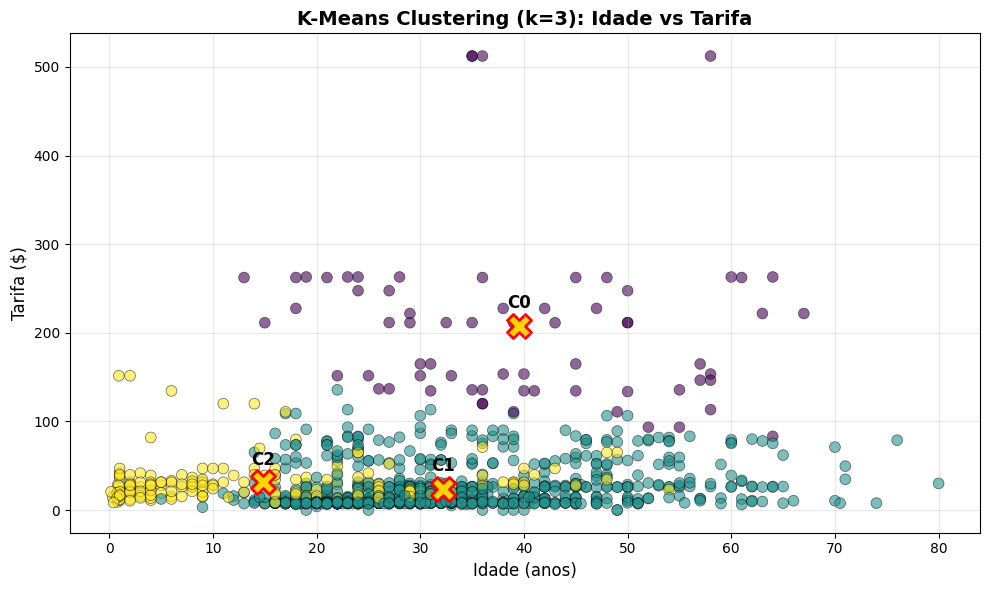

In [ ]:
# ===== 4. Escolher k = 3 =====
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
dados_titanic1["cluster"] = kmeans.fit_predict(X_scaled_df)

# ===== 6. Gráfico dos clusters (idade vs tarifa) =====
plt.figure(figsize=(10, 6))
scatter = plt.scatter(dados_titanic1["idade"],
                      dados_titanic1["tarifa"],
                      c=dados_titanic1["cluster"],
                      cmap='viridis',
                      s=60,
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=0.5)
# Adicionar centroides
for i, c in enumerate(centroides_reais):
    plt.scatter(c[0], c[1], marker="X", s=300, edgecolor="red", linewidth=2, c='gold')
    plt.text(c[0], c[1] + 20, f"C{i}", fontsize=12, fontweight='bold', ha='center')

plt.xlabel("Idade (anos)", fontsize=12)
plt.ylabel("Tarifa ($)", fontsize=12)
plt.title("K-Means Clustering (k=3): Idade vs Tarifa", fontsize=14, fontweight='bold')
#plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

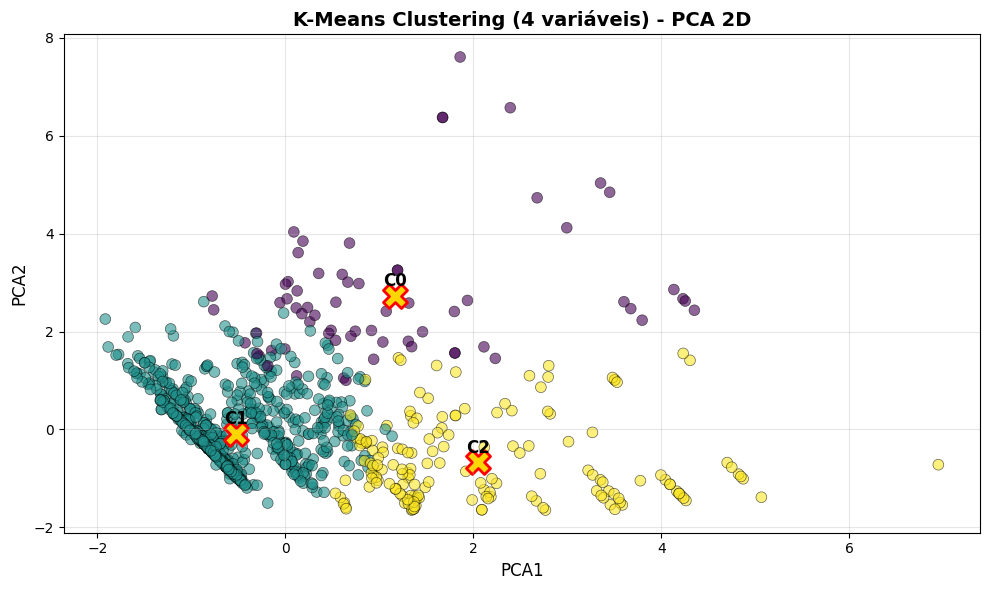

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ===== 1. Selecionar as variáveis =====
cols = ['idade','tarifa', "irmaos/conjuges_a_bordo", "pais/filhos_a_bordo"]
X = dados_titanic1[cols]

# ===== 2. Escalar os dados =====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===== 3. Aplicar K-Means =====
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
dados_titanic1["cluster"] = kmeans.fit_predict(X_scaled)

# ===== 4. Visualização 2D usando PCA =====
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c=dados_titanic1["cluster"],
                      cmap='viridis',
                      s=60,
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=0.5)

# Adicionar centroides no PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
for i, c in enumerate(centroids_pca):
    plt.scatter(c[0], c[1], marker="X", s=300, c='gold', edgecolor='red', linewidth=2)
    plt.text(c[0], c[1]+0.2, f"C{i}", fontsize=12, fontweight='bold', ha='center')

plt.xlabel("PCA1", fontsize=12)
plt.ylabel("PCA2", fontsize=12)
plt.title("K-Means Clustering (4 variáveis) - PCA 2D", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

# Lista para armazenar os resultados
resultados = []

for col in cols:
    groups = [dados_titanic1[dados_titanic1["cluster"] == cid][col] for cid in range(k)]
    
    # ANOVA
    f_stat, p_val = f_oneway(*groups)
    
    # Média geral
    grand_mean = np.mean(dados_titanic1[col])
    
    # Soma de quadrados entre e dentro
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_within = sum(sum((x - np.mean(g))**2 for x in g) for g in groups)
    
    # Eta² (proporção da variância explicada pelo cluster)
    eta_sq = ss_between / (ss_between + ss_within)
    
    resultados.append({
        'Variável': col,
        'F': f_stat,
        'SS_between': ss_between,
        'SS_within': ss_within,
        'Eta²': eta_sq,
        'p-valor': p_val
    })

# Transformar em DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir tabela bonita arredondando os valores
print(df_resultados.round(3))


                  Variável        F   SS_between    SS_within   Eta²  p-valor
0                    idade  152.257    48884.254   167274.816  0.226      0.0
1                   tarifa  952.946  2096547.883  1146236.443  0.647      0.0
2  irmaos/conjuges_a_bordo  204.409      244.938      624.300  0.282      0.0
3      pais/filhos_a_bordo  578.719      387.702      349.034  0.526      0.0


In [ ]:

# ===== 7. Estatísticas por cluster =====
print("\n=== ESTATÍSTICAS POR CLUSTER ===")
for cluster_id in range(k):
    cluster_data = dados_titanic1[dados_titanic1["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    print(cluster_data[cols].describe().loc[['mean', 'std', 'min', 'max']])



=== ESTATÍSTICAS POR CLUSTER ===

Cluster 0 (n=67):
          idade      tarifa  irmaos/conjuges_a_bordo  pais/filhos_a_bordo
mean  39.529851  207.480536                 0.686567             0.940299
std   13.821064   94.626283                 0.838631             1.028099
min   13.000000   83.158300                 0.000000             0.000000
max   67.000000  512.329200                 3.000000             4.000000

Cluster 1 (n=808):
          idade      tarifa  irmaos/conjuges_a_bordo  pais/filhos_a_bordo
mean  32.201114   23.656064                 0.262376             0.103960
std   12.499446   23.822848                 0.483144             0.336295
min    5.000000    0.000000                 0.000000             0.000000
max   80.000000  135.633300                 2.000000             2.000000

Cluster 2 (n=170):
          idade      tarifa  irmaos/conjuges_a_bordo  pais/filhos_a_bordo
mean  14.871588   31.303872                 1.576471             1.723529
std   13.005417   2